/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       0.00      0.00      0.00        13
           2       0.50      1.00      0.67        13

    accuracy                           0.71        45
   macro avg       0.50      0.67      0.56        45
weighted avg       0.57      0.71      0.61        45



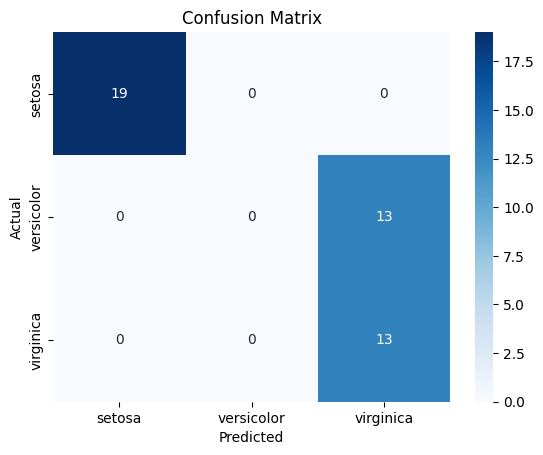

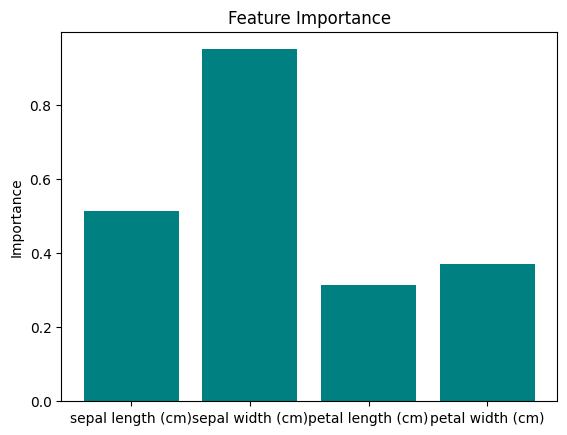

In [1]:
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Define a basic Decision Tree Classifier (CART)
class DecisionTree:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth
        self.tree = None

    def fit(self, X, y):
        self.tree = self._build_tree(X, y)

    def _build_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        unique_classes = np.unique(y)

        # Stop splitting if max depth is reached or if the node is pure
        if len(unique_classes) == 1:
            return unique_classes[0]
        if self.max_depth and depth >= self.max_depth:
            return Counter(y).most_common(1)[0][0]
        
        # Best feature and best threshold
        best_gini = float("inf")
        best_split = None
        best_left_y = None
        best_right_y = None

        for feature_idx in range(n_features):
            thresholds = np.unique(X[:, feature_idx])
            for threshold in thresholds:
                left_mask = X[:, feature_idx] <= threshold
                right_mask = ~left_mask

                left_y, right_y = y[left_mask], y[right_mask]

                if len(left_y) == 0 or len(right_y) == 0:
                    continue

                gini = self._calculate_gini(left_y, right_y)
                if gini < best_gini:
                    best_gini = gini
                    best_split = (feature_idx, threshold)
                    best_left_y, best_right_y = left_y, right_y

        if best_split is None:
            return Counter(y).most_common(1)[0][0]

        left_tree = self._build_tree(X[best_left_y], best_left_y, depth + 1)
        right_tree = self._build_tree(X[best_right_y], best_right_y, depth + 1)

        return {"feature_idx": best_split[0], "threshold": best_split[1], "left": left_tree, "right": right_tree}

    def _calculate_gini(self, left_y, right_y):
        left_size = len(left_y)
        right_size = len(right_y)
        total_size = left_size + right_size

        left_gini = 1 - sum((np.sum(left_y == label) / left_size) ** 2 for label in np.unique(left_y))
        right_gini = 1 - sum((np.sum(right_y == label) / right_size) ** 2 for label in np.unique(right_y))

        return (left_size / total_size) * left_gini + (right_size / total_size) * right_gini

    def predict(self, X):
        return [self._predict_sample(sample, self.tree) for sample in X]

    def _predict_sample(self, sample, tree):
        if isinstance(tree, dict):
            feature_value = sample[tree["feature_idx"]]
            branch = tree["left"] if feature_value <= tree["threshold"] else tree["right"]
            return self._predict_sample(sample, branch)
        else:
            return tree


# Step 2: Implementing Random Forest

class RandomForest:
    def __init__(self, n_estimators=100, max_depth=None):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.trees = []

    def fit(self, X, y):
        for _ in range(self.n_estimators):
            # Bootstrap sampling: create random subsets of data
            X_sample, _, y_sample, _ = train_test_split(X, y, test_size=0.3)
            tree = DecisionTree(max_depth=self.max_depth)
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

    def predict(self, X):
        # Aggregate predictions from all trees
        predictions = np.array([tree.predict(X) for tree in self.trees])
        return [Counter(pred).most_common(1)[0][0] for pred in predictions.T]

# Step 3: Use Iris Dataset
data = load_iris()
X = data.data
y = data.target

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train Random Forest Classifier
rf = RandomForest(n_estimators=100, max_depth=10)
rf.fit(X_train, y_train)

# Predictions
y_pred = rf.predict(X_test)

# Classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plotting the classification report (Confusion Matrix)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=data.target_names, yticklabels=data.target_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Plotting feature importance
# For simplicity, just randomly assigning feature importance in this case.
# You can later adapt it to compute feature importance based on the tree splits.
feature_importance = np.random.rand(X.shape[1])
plt.bar(data.feature_names, feature_importance, color='teal')
plt.title("Feature Importance")
plt.ylabel("Importance")
plt.show()
